# 様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)
2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加; iii. DBSCANクラスターに帰属する個数の相関をHeatmap にする処理を追加
2024/06/30 i. ngrams_skippy.py, ngrams.py の参照を gen_ngrams.py に更新．それにより，skippy4gram の追加; ii. unicode character decomposition を無効化．これにより，アクセント記号を整合的に扱えるようになった

# Settings

In [157]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp

## module 探索範囲の拡張
sys.path.append('..')

設定

In [158]:
## 処理設定
verbose = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [159]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics      = 15 # 30は多過ぎる？

## DTM term の最低頻度
term_min_freq = 3

## DTM 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.10

### DTM 構築: doc, term の設定
## doc
doc_type       = 'form'  # 変更不可
doc_attrs      = [ 'spell', 'sound' ]
doc_attr       = doc_attrs[1]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size   = 13
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size   = 3
print(f"min_doc_size: {min_doc_size}")

## boundary marking
mark_boundaries = True
boundary_mark   = "#"

## term
term_size         = 'character' # 出力用の名目変数
term_types        = [ '1gram', '2gram', '3gram', '4gram', '5gram'
                     'skippy_2gram', 'skippy_3gram', 'skippy_4gram', 'skippy_5gram' ]
lda_term_type     = term_types[-3]
print(f"lda_term_type: {lda_term_type}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True
inclusion_degree   = 1 # With the value k, (n-k) grams are included in n-grams

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_gap_size = round(max_doc_size * 0.8)
print(f"max_gap_size for skippy n-grams: {max_gap_size}")

doc_attr: sound
max_doc_size: 13
min_doc_size: 3
lda_term_type: skippy_3gram
max_gap_size for skippy n-grams: 10


In [160]:
## FastText を使うか (LDA と併用可能)
use_FastText         = True

## term
ft_uses_its_own_term = True
ft_term_types = [ '1gram', '2gram', '3gram', '4gram', '5gram',
                 'skippy_2gram', 'skippy_3gram', 'skippy_4gram', 'skippy_4gram' ]
if ft_uses_its_own_term:
    ft_term_type = ft_term_types[3]
else:
    ft_term_type = lda_term_type
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 4gram
ft_window_size: 5
ft_n_dims: 30


In [161]:
## 設定の確認
assert use_LDA or use_FastText
if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"

In [162]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [163]:
## UMAP の設定
## correlation の他のmetric は良くない
umap_metrics     = [ 'correlation',
                    'cosine', 'euclidean', 'braycurtis', 'canberra', 'manhattan', 'minkowski'
                    'mahalanobis' ]
umap_metric      = umap_metrics[0]

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

In [164]:
## DBSCAN clustering 用
DBSCAN_uses_UMAP = True # False ならtSNE を使う

# 言語の選別

In [165]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [166]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, \
    japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, \
    japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
selected_langs = re.split(r",\s*", sound_set1)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 11 languages:
['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']


In [167]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [168]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
11 langs are targeted
{'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}


In [169]:
## function to undo Unicode character decomposition
import unicodedata
def undecompose(W: list):
    # Crucially! str(..)
    return [ unicodedata.normalize('NFC', str(x)) for x in W ]

In [170]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                ## undo Unicode character decompostion
                dfx['form'] = undecompose(dfx['form'])
                ##
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-sound-Icelandic-r0-1k-mc.csv
reading: data-words/base-spell-Icelandic-r0-original.csv
reading: data-words/base-sou

In [171]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [172]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

## boundary mark の追加
if mark_boundaries:
    raw_df[doc_type] = raw_df[doc_type].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
##
raw_df[doc_type]

0      #kamaː#
1      #ʔanaː#
2       #lahu#
3        #ʔan#
4       #huːa#
        ...   
703    #zaidi#
704    #ziara#
705     #zima#
706     #ziwa#
707    #zoezi#
Name: form, Length: 25291, dtype: object

In [173]:
## 言語名= language の列を追加

check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df['language']

0       arabic
1       arabic
2       arabic
3       arabic
4       arabic
        ...   
703    swahili
704    swahili
705    swahili
706    swahili
707    swahili
Name: language, Length: 25291, dtype: object

In [174]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df['family']

0       arabic
1       arabic
2       arabic
3       arabic
4       arabic
        ...   
703    swahili
704    swahili
705    swahili
706    swahili
707    swahili
Name: family, Length: 25291, dtype: object

In [175]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df['size']

0      7
1      7
2      6
3      5
4      6
      ..
703    7
704    7
705    6
706    6
707    7
Name: size, Length: 25291, dtype: int64

In [176]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: sound


,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,#kamaː#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,7
1,#ʔanaː#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,7
2,#lahu#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,6
3,#ʔan#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
4,#huːa#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,#pua#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
879,#wiᵑgi#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7
880,#hasiɾa#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,8
881,#maɗai#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7


In [177]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,#kamaː#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,7
1,#ʔanaː#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,7
2,#lahu#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,6
3,#ʔan#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
4,#huːa#,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,#pua#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
879,#wiᵑgi#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7
880,#hasiɾa#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,8
881,#maɗai#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63296/1748787432.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



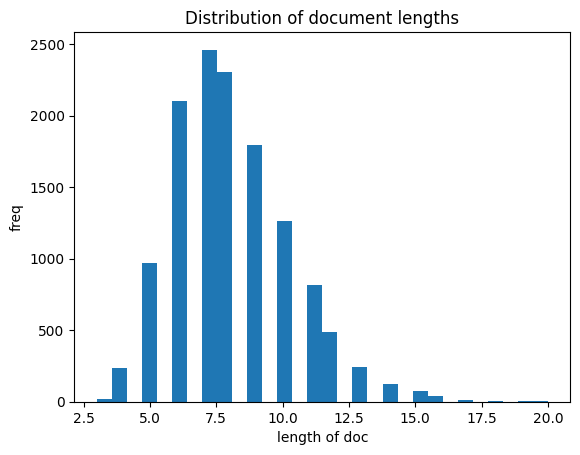

In [178]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of document lengths")
fig.show()

データを長さで濾過

In [179]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 13
258 cases removed due to max_doc_size
min doc size: 3
0 cases removed due to min_doc_size
258 cases removed in total


In [180]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
0    12706
Name: count, dtype: int64
sound
1    12706
Name: count, dtype: int64


In [181]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    11982
1      724
Name: count, dtype: int64
dutch
0    11624
1     1082
Name: count, dtype: int64
english
0    8605
1    4101
Name: count, dtype: int64
esperanto
0    11952
1      754
Name: count, dtype: int64
french
0    11747
1      959
Name: count, dtype: int64
german
0    11918
1      788
Name: count, dtype: int64
icelandic
0    11777
1      929
Name: count, dtype: int64
japanese
0    11888
1      818
Name: count, dtype: int64
korean
0    11985
1      721
Name: count, dtype: int64
spanish
0    11757
1      949
Name: count, dtype: int64
swahili
0    11825
1      881
Name: count, dtype: int64


英語事例の割合補正

In [182]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
429,#dɪlɪvəɹɪ#,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,10
2371,#slaɪd#,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,7
4051,#ɡɛst#,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,6
3597,#ɑɹməɹ#,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,7
2249,#pɹɪnt#,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,#pua#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
879,#wiᵑgi#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7
880,#hasiɾa#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,8
881,#maɗai#,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,7


In [183]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    8701
1     724
Name: count, dtype: int64
dutch
0    8343
1    1082
Name: count, dtype: int64
english
0    8605
1     820
Name: count, dtype: int64
esperanto
0    8671
1     754
Name: count, dtype: int64
french
0    8466
1     959
Name: count, dtype: int64
german
0    8637
1     788
Name: count, dtype: int64
icelandic
0    8496
1     929
Name: count, dtype: int64
japanese
0    8607
1     818
Name: count, dtype: int64
korean
0    8704
1     721
Name: count, dtype: int64
spanish
0    8476
1     949
Name: count, dtype: int64
swahili
0    8544
1     881
Name: count, dtype: int64


In [184]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

In [185]:
# name the shared variable
bases = main_df[doc_type]
bases

914       #raːða#
165      #buskaɾ#
49       #dəvɛ̃s#
173       #forto#
42       #atendi#
          ...    
364    #basiːtˤa#
692     #œːrʏkʏr#
1          #aero#
93     #çidʑoɯni#
236     #kaʁaktɐ#
Name: form, Length: 9425, dtype: object

# n-grams の生成

In [186]:
## n-gram 追加のルーチン
def add_ngrams(dfx, n_for_ngram: int = 2, skippy: bool = False, prefix: str = "", seg_joint: str = "", gap_mark: str = "…", max_distance = None, inclusive: bool = True, inclusion_degree = None, check: bool = False):
    """
    add n-gram col to df
    """
    import gen_ngrams
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name = f"skippy_{prefix}{n_for_ngram}gram"
    else:
        target_var_name = f"{prefix}{n_for_ngram}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
    ## define souruce var
    unigrams = dfx[source_var_name]
    ## generate n-grams
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, max_distance = max_distance, sep = seg_joint, missing_mark = gap_mark, check = check) for x in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]

    ## n-gram を包括的にする場合
    if inclusive:
        sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        sub_ngrams = dfx[sub_var_name]
        if inclusion_degree is None:
            ngrams = [ [*a, *b ] for a, b in zip(ngrams, sub_ngrams) ]
        elif inclusion_degree >= 0:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            ngrams = [ [ *a, *[ x for x in b if len(x) >= min_size ] ] for 
                      a, b in zip(ngrams, sub_ngrams) ]
        else:
            raise "ValueError"

    ## n-gram列の追加
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

In [187]:
## 1gram 列の追加
unigrams = bases.apply(lambda x: re.split(r"", x))

## remove null elements
unigrams = [ [ u for u in x if len(u) > 0 ] for x in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
main_df['1gram']

914             [#, r, a, ː, ð, a, #]
165          [#, b, u, s, k, a, ɾ, #]
49           [#, d, ə, v, ɛ, ̃, s, #]
173             [#, f, o, r, t, o, #]
42           [#, a, t, e, n, d, i, #]
                    ...              
364    [#, b, a, s, i, ː, t, ˤ, a, #]
692       [#, œ, ː, r, ʏ, k, ʏ, r, #]
1                  [#, a, e, r, o, #]
93     [#, ç, i, d, ʑ, o, ɯ, n, i, #]
236       [#, k, a, ʁ, a, k, t, ɐ, #]
Name: 1gram, Length: 9425, dtype: object

In [188]:
## 2gram の追加
add_ngrams(main_df, n_for_ngram = 2, seg_joint = "", check = False)

914        [#r, ra, aː, ːð, ða, a#, #, r, a, ː, ð, a, #]
165    [#b, bu, us, sk, ka, aɾ, ɾ#, #, b, u, s, k, a,...
49     [#d, də, əv, vɛ, ɛ̃, ̃s, s#, #, d, ə, v, ɛ, ̃,...
173        [#f, fo, or, rt, to, o#, #, f, o, r, t, o, #]
42     [#a, at, te, en, nd, di, i#, #, a, t, e, n, d,...
                             ...                        
364    [#b, ba, as, si, iː, ːt, tˤ, ˤa, a#, #, b, a, ...
692    [#œ, œː, ːr, rʏ, ʏk, kʏ, ʏr, r#, #, œ, ː, r, ʏ...
1                 [#a, ae, er, ro, o#, #, a, e, r, o, #]
93     [#ç, çi, id, dʑ, ʑo, oɯ, ɯn, ni, i#, #, ç, i, ...
236    [#k, ka, aʁ, ʁa, ak, kt, tɐ, ɐ#, #, k, a, ʁ, a...
Name: 2gram, Length: 9425, dtype: object


In [189]:
## 3gram の追加
add_ngrams(main_df, n_for_ngram = 3, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

914    [#ra, raː, aːð, ːða, ða#, #r, ra, aː, ːð, ða, a#]
165    [#bu, bus, usk, ska, kaɾ, aɾ#, #b, bu, us, sk,...
49     [#də, dəv, əvɛ, vɛ̃, ɛ̃s, ̃s#, #d, də, əv, vɛ,...
173    [#fo, for, ort, rto, to#, #f, fo, or, rt, to, o#]
42     [#at, ate, ten, end, ndi, di#, #a, at, te, en,...
                             ...                        
364    [#ba, bas, asi, siː, iːt, ːtˤ, tˤa, ˤa#, #b, b...
692    [#œː, œːr, ːrʏ, rʏk, ʏkʏ, kʏr, ʏr#, #œ, œː, ːr...
1               [#ae, aer, ero, ro#, #a, ae, er, ro, o#]
93     [#çi, çid, idʑ, dʑo, ʑoɯ, oɯn, ɯni, ni#, #ç, ç...
236    [#ka, kaʁ, aʁa, ʁak, akt, ktɐ, tɐ#, #k, ka, aʁ...
Name: 3gram, Length: 9425, dtype: object


In [190]:
## 4gram の追加
add_ngrams(main_df, n_for_ngram = 4, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

914    [#raː, raːð, aːða, ːða#, #ra, raː, aːð, ːða, ða#]
165    [#bus, busk, uska, skaɾ, kaɾ#, #bu, bus, usk, ...
49     [#dəv, dəvɛ, əvɛ̃, vɛ̃s, ɛ̃s#, #də, dəv, əvɛ, ...
173    [#for, fort, orto, rto#, #fo, for, ort, rto, to#]
42     [#ate, aten, tend, endi, ndi#, #at, ate, ten, ...
                             ...                        
364    [#bas, basi, asiː, siːt, iːtˤ, ːtˤa, tˤa#, #ba...
692    [#œːr, œːrʏ, ːrʏk, rʏkʏ, ʏkʏr, kʏr#, #œː, œːr,...
1                 [#aer, aero, ero#, #ae, aer, ero, ro#]
93     [#çid, çidʑ, idʑo, dʑoɯ, ʑoɯn, oɯni, ɯni#, #çi...
236    [#kaʁ, kaʁa, aʁak, ʁakt, aktɐ, ktɐ#, #ka, kaʁ,...
Name: 4gram, Length: 9425, dtype: object


In [191]:
## 5gram の追加
if "5gram" in lda_term_type:
    add_ngrams(main_df, n_for_ngram = 5, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

In [192]:
## skippy 2gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 2, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, max_distance = max_gap_size, check = False)

914    [#r, #…a, #…ː, #…ð, #…a, #…#, ra, r…ː, r…ð, r…...
165    [#b, #…u, #…s, #…k, #…a, #…ɾ, #…#, bu, b…s, b…...
49     [#d, #…ə, #…v, #…ɛ, #…̃, #…s, #…#, də, d…v, d…...
173    [#f, #…o, #…r, #…t, #…o, #…#, fo, f…r, f…t, f…...
42     [#a, #…t, #…e, #…n, #…d, #…i, #…#, at, a…e, a…...
                             ...                        
364    [#b, #…a, #…s, #…i, #…ː, #…t, #…ˤ, #…a, #…#, b...
692    [#œ, #…ː, #…r, #…ʏ, #…k, #…ʏ, #…r, #…#, œː, œ…...
1      [#a, #…e, #…r, #…o, #…#, ae, a…r, a…o, a…#, er...
93     [#ç, #…i, #…d, #…ʑ, #…o, #…ɯ, #…n, #…i, #…#, ç...
236    [#k, #…a, #…ʁ, #…a, #…k, #…t, #…ɐ, #…#, ka, k…...
Name: skippy_2gram, Length: 9425, dtype: object


In [193]:
## skippy 3gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 3, seg_joint = "", inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, max_distance = max_gap_size, check = False)

914    [#ra, #r…ː, #r…ð, #r…a, #r…#, #…aː, #…a…ð, #…a...
165    [#bu, #b…s, #b…k, #b…a, #b…ɾ, #b…#, #…us, #…u…...
49     [#də, #d…v, #d…ɛ, #d…̃, #d…s, #d…#, #…əv, #…ə…...
173    [#fo, #f…r, #f…t, #f…o, #f…#, #…or, #…o…t, #…o...
42     [#at, #a…e, #a…n, #a…d, #a…i, #a…#, #…te, #…t…...
                             ...                        
364    [#ba, #b…s, #b…i, #b…ː, #b…t, #b…ˤ, #b…a, #b…#...
692    [#œː, #œ…r, #œ…ʏ, #œ…k, #œ…ʏ, #œ…r, #œ…#, #…ːr...
1      [#ae, #a…r, #a…o, #a…#, #…er, #…e…o, #…e…#, #…...
93     [#çi, #ç…d, #ç…ʑ, #ç…o, #ç…ɯ, #ç…n, #ç…i, #ç…#...
236    [#ka, #k…ʁ, #k…a, #k…k, #k…t, #k…ɐ, #k…#, #…aʁ...
Name: skippy_3gram, Length: 9425, dtype: object


In [194]:
## skippy 4gram の追加
add_ngrams(main_df, skippy = True, n_for_ngram = 4, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, seg_joint = "", max_distance = max_gap_size, check = False)

914    [#raː, #ra…ð, #ra…a, #ra…#, #r…ːð, #r…ː…a, #r…...
165    [#bus, #bu…k, #bu…a, #bu…ɾ, #bu…#, #b…sk, #b…s...
49     [#dəv, #də…ɛ, #də…̃, #də…s, #də…#, #d…vɛ, #d…v...
173    [#for, #fo…t, #fo…o, #fo…#, #f…rt, #f…r…o, #f…...
42     [#ate, #at…n, #at…d, #at…i, #at…#, #a…en, #a…e...
                             ...                        
364    [#bas, #ba…i, #ba…ː, #ba…t, #ba…ˤ, #ba…a, #ba…...
692    [#œːr, #œː…ʏ, #œː…k, #œː…ʏ, #œː…r, #œː…#, #œ…r...
1      [#aer, #ae…o, #ae…#, #a…ro, #a…r…#, #a…o#, #…e...
93     [#çid, #çi…ʑ, #çi…o, #çi…ɯ, #çi…n, #çi…i, #çi…...
236    [#kaʁ, #ka…a, #ka…k, #ka…t, #ka…ɐ, #ka…#, #k…ʁ...
Name: skippy_4gram, Length: 9425, dtype: object


In [195]:
## skippy 5gram の追加
if "5gram" in lda_term_type:
    add_ngrams(main_df, skippy = True, n_for_ngram = 5, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, seg_joint = "", max_distance = max_gap_size, check = False)

In [196]:
main_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,...,language,family,size,1gram,2gram,3gram,4gram,skippy_2gram,skippy_3gram,skippy_4gram
914,#raːða#,1.0,0,1,0,0,0,0,0,0,...,icelandic,germanic,7,"[#, r, a, ː, ð, a, #]","[#r, ra, aː, ːð, ða, a#, #, r, a, ː, ð, a, #]","[#ra, raː, aːð, ːða, ða#, #r, ra, aː, ːð, ða, a#]","[#raː, raːð, aːða, ːða#, #ra, raː, aːð, ːða, ða#]","[#r, #…a, #…ː, #…ð, #…a, #…#, ra, r…ː, r…ð, r…...","[#ra, #r…ː, #r…ð, #r…a, #r…#, #…aː, #…a…ð, #…a...","[#raː, #ra…ð, #ra…a, #ra…#, #r…ːð, #r…ː…a, #r…..."
165,#buskaɾ#,1.0,0,1,0,0,0,0,0,0,...,spanish,romance,8,"[#, b, u, s, k, a, ɾ, #]","[#b, bu, us, sk, ka, aɾ, ɾ#, #, b, u, s, k, a,...","[#bu, bus, usk, ska, kaɾ, aɾ#, #b, bu, us, sk,...","[#bus, busk, uska, skaɾ, kaɾ#, #bu, bus, usk, ...","[#b, #…u, #…s, #…k, #…a, #…ɾ, #…#, bu, b…s, b…...","[#bu, #b…s, #b…k, #b…a, #b…ɾ, #b…#, #…us, #…u…...","[#bus, #bu…k, #bu…a, #bu…ɾ, #bu…#, #b…sk, #b…s..."
49,#dəvɛ̃s#,1.0,0,1,0,0,0,0,1,0,...,french,romance,8,"[#, d, ə, v, ɛ, ̃, s, #]","[#d, də, əv, vɛ, ɛ̃, ̃s, s#, #, d, ə, v, ɛ, ̃,...","[#də, dəv, əvɛ, vɛ̃, ɛ̃s, ̃s#, #d, də, əv, vɛ,...","[#dəv, dəvɛ, əvɛ̃, vɛ̃s, ɛ̃s#, #də, dəv, əvɛ, ...","[#d, #…ə, #…v, #…ɛ, #…̃, #…s, #…#, də, d…v, d…...","[#də, #d…v, #d…ɛ, #d…̃, #d…s, #d…#, #…əv, #…ə…...","[#dəv, #də…ɛ, #də…̃, #də…s, #də…#, #d…vɛ, #d…v..."
173,#forto#,1.0,0,1,0,0,0,1,0,0,...,esperanto,romance,7,"[#, f, o, r, t, o, #]","[#f, fo, or, rt, to, o#, #, f, o, r, t, o, #]","[#fo, for, ort, rto, to#, #f, fo, or, rt, to, o#]","[#for, fort, orto, rto#, #fo, for, ort, rto, to#]","[#f, #…o, #…r, #…t, #…o, #…#, fo, f…r, f…t, f…...","[#fo, #f…r, #f…t, #f…o, #f…#, #…or, #…o…t, #…o...","[#for, #fo…t, #fo…o, #fo…#, #f…rt, #f…r…o, #f…..."
42,#atendi#,1.0,0,1,0,0,0,1,0,0,...,esperanto,romance,8,"[#, a, t, e, n, d, i, #]","[#a, at, te, en, nd, di, i#, #, a, t, e, n, d,...","[#at, ate, ten, end, ndi, di#, #a, at, te, en,...","[#ate, aten, tend, endi, ndi#, #at, ate, ten, ...","[#a, #…t, #…e, #…n, #…d, #…i, #…#, at, a…e, a…...","[#at, #a…e, #a…n, #a…d, #a…i, #a…#, #…te, #…t…...","[#ate, #at…n, #at…d, #at…i, #at…#, #a…en, #a…e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,#basiːtˤa#,1.0,0,1,1,0,0,0,0,0,...,arabic,arabic,10,"[#, b, a, s, i, ː, t, ˤ, a, #]","[#b, ba, as, si, iː, ːt, tˤ, ˤa, a#, #, b, a, ...","[#ba, bas, asi, siː, iːt, ːtˤ, tˤa, ˤa#, #b, b...","[#bas, basi, asiː, siːt, iːtˤ, ːtˤa, tˤa#, #ba...","[#b, #…a, #…s, #…i, #…ː, #…t, #…ˤ, #…a, #…#, b...","[#ba, #b…s, #b…i, #b…ː, #b…t, #b…ˤ, #b…a, #b…#...","[#bas, #ba…i, #ba…ː, #ba…t, #ba…ˤ, #ba…a, #ba…..."
692,#œːrʏkʏr#,1.0,0,1,0,0,0,0,0,0,...,icelandic,germanic,9,"[#, œ, ː, r, ʏ, k, ʏ, r, #]","[#œ, œː, ːr, rʏ, ʏk, kʏ, ʏr, r#, #, œ, ː, r, ʏ...","[#œː, œːr, ːrʏ, rʏk, ʏkʏ, kʏr, ʏr#, #œ, œː, ːr...","[#œːr, œːrʏ, ːrʏk, rʏkʏ, ʏkʏr, kʏr#, #œː, œːr,...","[#œ, #…ː, #…r, #…ʏ, #…k, #…ʏ, #…r, #…#, œː, œ…...","[#œː, #œ…r, #œ…ʏ, #œ…k, #œ…ʏ, #œ…r, #œ…#, #…ːr...","[#œːr, #œː…ʏ, #œː…k, #œː…ʏ, #œː…r, #œː…#, #œ…r..."
1,#aero#,1.0,0,1,0,0,0,1,0,0,...,esperanto,romance,6,"[#, a, e, r, o, #]","[#a, ae, er, ro, o#, #, a, e, r, o, #]","[#ae, aer, ero, ro#, #a, ae, er, ro, o#]","[#aer, aero, ero#, #ae, aer, ero, ro#]","[#a, #…e, #…r, #…o, #…#, ae, a…r, a…o, a…#, er...","[#ae, #a…r, #a…o, #a…#, #…er, #…e…o, #…e…#, #…...","[#aer, #ae…o, #ae…#, #a…ro, #a…r…#, #a…o#, #…e..."
93,#çidʑoɯni#,1.0,0,1,0,0,0,0,0,0,...,japanese,japanese,10,"[#, ç, i, d, ʑ, o, ɯ, n, i, #]","[#ç, çi, id, dʑ, ʑo, oɯ, ɯn, ni, i#, #, ç, i, ...","[#çi, çid, idʑ, dʑo, ʑoɯ, oɯn, ɯni, ni#, #ç, ç...","[#çid, çidʑ, idʑo, dʑoɯ, ʑoɯn, oɯni, ɯni#, #çi...","[#ç, #…i, #…d, #…ʑ, #…o, #…ɯ, #…n, #…i, #…#, ç...","[#çi, #ç…d, #ç…ʑ, #ç…o, #ç…ɯ, #ç…n, #ç…i, #ç…#...","[#çid, #çi…ʑ, #çi…o, #çi…ɯ, #çi…n, #çi…i, #çi…..."


# DTM 構築

In [197]:
## LDA 構築の基になる DTM を構築

from gensim.corpora.dictionary import Dictionary
bots = main_df[lda_term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<103800 unique tokens: ['#r', '#ra', '#r…#', '#r…a', '#r…ð']...>


In [198]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 3
abuse filter: 0.1
Dictionary<41834 unique tokens: ['#r', '#ra', '#r…#', '#r…a', '#r…ð']...>


In [199]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
check = False
if check:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 9425


LDA モデルの構築

In [200]:
## LDA モデルの構築
from gensim.models import LdaModel as LDAmodel
print(f"Building LDA model with n_topics: {n_topics}")
doc_lda = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15
LdaModel<num_terms=103800, num_topics=15, decay=0.5, chunksize=2000>


In [201]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15
0,ʏr#,st…#,aː…#,iː…#,a…o#,i…a#,ʁ…e#,wa…#,a…a…#,ːl#,a…a#,a̠…#,ɾɯ#,ɔ̃#,no#
1,ːr#,a…t#,a…a#,t…ː…#,e…o#,#…i…#,əʁ…#,ə…t#,#…a…#,uː…#,al…#,a…n#,a…ɯ#,j…̃#,a̠…#
2,e…a#,te#,a…a…#,i…a…#,to#,i…i#,ɑ̃…#,a…ɪ#,a…a#,ma…#,u…a#,en…#,ɯ…ɯ#,jɔ…#,k̚#
3,t…r#,t#,a…a…a,#…i…#,i…o#,i…i…#,je#,ɾa#,a…i#,m…ː…#,#…a…#,nt…#,t…ɯ#,jɔ̃,əɹ#
4,a…r#,st#,#…a…#,a…i…#,t…o#,͡ɕ…#,ə…e#,wa#,ta…#,ɪ…n#,la…#,d͡ʑ,i…ɯ#,#…ɛ…#,ɾ…o#
5,i…r#,#…t#,aːl,#…ː…#,o#,u…i…#,nd…#,a…a#,#…a…a,ʃə…#,l…a#,͡ʑ…#,#…ɯ…#,ːv…#,e…o#
6,ː…r#,ta#,aː…a,ː…ə#,n…o#,k…a#,̃…ʁ…#,#…a…#,ka…#,ən#,na#,#…e…#,ɯ#,ɛn…#,ʰa̠
7,e…e…#,ː…t#,#…a…a,l…ː…#,o…o#,əl#,ʁa#,ɾa…#,ɾi#,a…l#,a…a…#,d͡…#,e…ɯ#,ɛi…#,ʰa…#
8,ː…ʏ…#,t…t#,ː…a…#,ːt…#,#…o#,i…a…#,ʁj…#,a…t#,ðo#,#…a…#,#…a…a,d…ʑ…#,sɯ#,s…̃#,sʰ…#
9,uː…#,nt#,ːl…a,eː…#,k…o#,k…i…#,as#,ɪ…t#,a…t…#,ɪ…ə…#,an…#,e…t…#,#…ɯ#,u…a#,a…ŋ#


LDAvis の実行

In [202]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [203]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if verbose:
    topic_dist

In [204]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[0.99999994 1.         0.9999999  1.         1.0000002  0.99999994
 0.99999976 0.9999998  0.99999994 1.         1.0000001  0.99999976
 1.         1.0000001  0.9999998 ]


In [205]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

14.999996


In [206]:
## term エンコード値の分布を確認
if verbose:
    import matplotlib.pyplot as plt

    plt.figure(figsize = (4,4))
    df_size = len(topic_dist)
    sampling_rate = 0.5
    sample_n = round(df_size * sampling_rate)
    topic_sampled = random.sample(list(topic_dist), sample_n)

    T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
    plt.plot(T, range(len(T)))
    plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
    plt.show()

In [207]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [208]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [209]:
## LDA モデルを使って doc をエンコード

print(f"get LDA encodings for documents")
check    = False
lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    lda_encoding.append([ e[-1] for e in enc ])
#
pp.pprint(random.sample(lda_encoding, 2))
print(f"#documents processed: {len(lda_encoding)}")

get LDA encodings for documents
[[0.0001407749,
  0.0001407749,
  0.0001407749,
  0.07457755,
  0.0001407749,
  0.3783174,
  0.0001407749,
  0.45959398,
  0.0001407749,
  0.0001407749,
  0.08596256,
  0.0001407749,
  0.0001407749,
  0.0001407749,
  0.0001407749],
 [8.6278946e-05,
  0.34428477,
  8.6278946e-05,
  8.6278946e-05,
  0.05754605,
  8.6278946e-05,
  0.21836907,
  8.6278946e-05,
  8.6278946e-05,
  8.6278946e-05,
  0.18253967,
  8.6278946e-05,
  8.6278946e-05,
  0.19639763,
  8.6278946e-05]]
#documents processed: 9425


In [210]:
## FastText を使ったエンコードの準備
from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")
## emulate sentences by concatenating character 1-grams by whitespaces
ft_term_seg_joint = " "
ft_corpus = [ ft_term_seg_joint.join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 3)


get FastText encodings for documents


['#deb debʁ ebʁi bʁid ʁidə idəʁ dəʁɛ əʁɛ# #de deb ebʁ bʁi ʁid idə dəʁ əʁɛ ʁɛ#',
 '#xus xust usto sto# #xu xus ust sto to#',
 '#kɯ# #kɯ kɯ#']

In [211]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(random.sample(ft_encoding, 1))
print(f"data size: {len(ft_encoding)}")

[array([-1.0951151e-03, -6.3815934e-04, -1.3708487e-03, -1.1712802e-03,
       -1.4450655e-03, -2.1705306e-03, -2.5206371e-03,  3.4609183e-03,
       -1.1868803e-03, -1.7446909e-03,  2.1463607e-03, -1.9224592e-04,
        3.7063254e-04,  1.2686256e-03, -1.4304412e-03,  1.0444120e-03,
        1.7938010e-03,  1.6500526e-03,  2.4252760e-03, -1.1989189e-03,
       -1.5831054e-03, -3.3312128e-03,  2.4099101e-03, -6.0419750e-04,
        8.5702358e-04,  1.6877826e-03, -1.0002108e-03,  7.1650778e-05,
        7.3964009e-04, -1.4383250e-03], dtype=float32)]
data size: 9425


In [212]:
## doc_encoding の選択
if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[array([3.482671672827564e-05, 3.482671672827564e-05,
       3.482671672827564e-05, 3.482671672827564e-05,
       3.482671672827564e-05, 3.482671672827564e-05,
       3.482671672827564e-05, 3.482671672827564e-05, 0.7060001492500305,
       3.482671672827564e-05, 3.482671672827564e-05, 0.2935471534729004,
       3.482671672827564e-05, 3.482671672827564e-05,
       3.482671672827564e-05, 0.0006657292833551764,
       0.00045342318480834365, 0.0016825604252517223,
       -0.0013682548888027668, 0.00011911168257938698,
       0.0015660763019695878, 0.0001907704136101529,
       -0.001595518784597516, 0.0005896989023312926,
       0.0024977673310786486, -0.0006598750478588045,
       4.6223056415328756e-05, 0.0018933368846774101,
       -0.0012665577232837677, 0.0017761951312422752,
       -0.0022263277787715197, -0.0024998467415571213,
       0.0004944049287587404, -0.0020486414432525635,
       0.0008896958315744996, -0.0003866806800942868,
       -0.0020670525263994932, -0.00162038300186

In [213]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

914    [0.0001314025721512735, 0.0001314025721512735,...
165    [0.028922101482748985, 7.807575457263738e-05, ...
49     [7.616721995873377e-05, 7.616721995873377e-05,...
173    [0.0001320223673246801, 0.0001320223673246801,...
42     [7.513025047956035e-05, 7.513025047956035e-05,...
                             ...                        
364    [3.189758353983052e-05, 3.189758353983052e-05,...
692    [0.8186206817626953, 7.262094732141122e-05, 7....
1      [0.0002846437564585358, 0.0002846437564585358,...
93     [5.000306191504933e-05, 5.000306191504933e-05,...
236    [6.849314377177507e-05, 0.046754155308008194, ...
Name: enc, Length: 9425, dtype: object

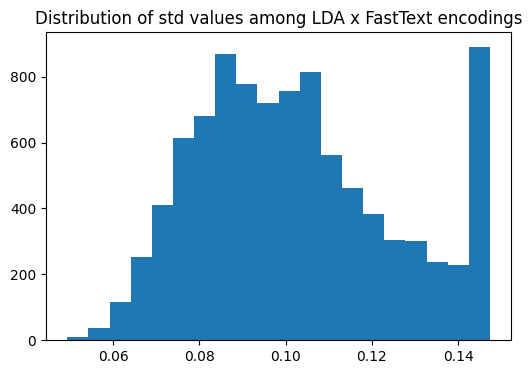

In [214]:
## 濾過前のエンコーディングのstd の分布を確認
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [215]:
## 一様分布の事例を除外
import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.04931197203592578
std 2nd min: 0.14740866955730206


In [216]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 6 # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

9425 instances before filtering
std_threshold: 0.024568111592883676
Filtering leaves 9425 instances: (0 instances removed)


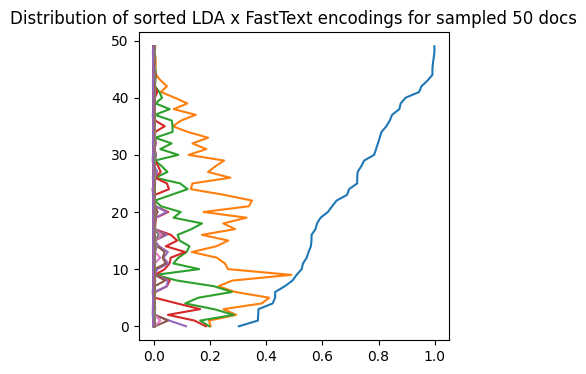

In [217]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [218]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic        724
dutch        1082
english       820
esperanto     754
french        959
german        788
icelandic     929
japanese      818
korean        721
spanish       949
swahili       881
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [219]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 1885 rows after sampling


In [220]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'dutch', 'english',
       'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean',
       'spanish', 'swahili', 'language', 'family', 'size', '1gram', '2gram',
       '3gram', '4gram', 'skippy_2gram', 'skippy_3gram', 'skippy_4gram',
       'enc'],
      dtype='object')

In [221]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       132
dutch        226
english      165
esperanto    152
french       197
german       154
icelandic    184
japanese     157
korean       133
spanish      181
swahili      204
Name: count, dtype: int64

In [222]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic      132
english     165
germanic    564
japanese    157
korean      133
romance     530
swahili     204
Name: count, dtype: int64

# UMAP を使った可視化 (3D)

In [223]:
## 必要に応じて
#!pip install -U ipywidgets

In [224]:
## UMAP を使った documents のグループ化
import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric,
                    n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

In [225]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])
#
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(umap_df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [226]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
max_perplexity_factor = 3
perplexity_max_val = round(len(doc_fit_df)/max_perplexity_factor)
print(f"perplexity_max_val: {perplexity_max_val}")

divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
df_size = len(doc_fit_df)
exit_after_step = 3 # 15 is largest enough to complete the all steps
ppl_vals = enumerate(range(5, perplexity_max_val, perplexity_increment))
for step, ppl_val in ppl_vals:
    ## 早期終了の判定
    if step >= exit_after_step:
        continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                          max_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ##
    X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(main_df[colored_var]):
        traced = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = traced['D1'], y = traced['D2'], z = traced['D3'],
                name = lang.title(), mode = 'markers', marker = dict(size = 3),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
    if use_FastText:
        if use_LDA:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
    title_val = title_header + title_body
    fig.update_layout(title = dict(text = title_val, font_size = 13),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 628
perplexity_increment: 126


In [227]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



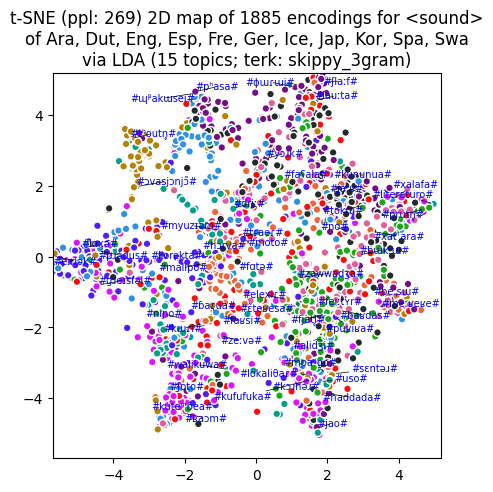

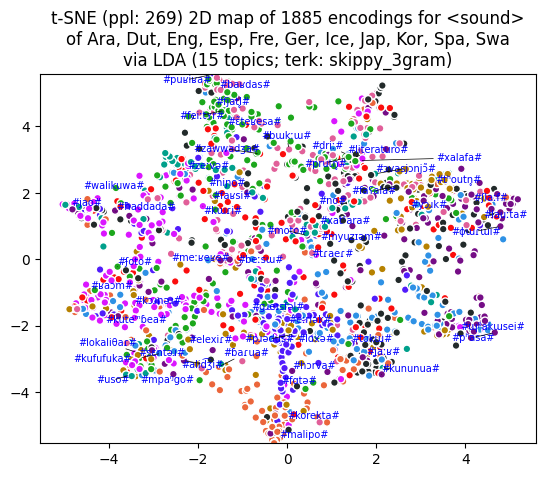

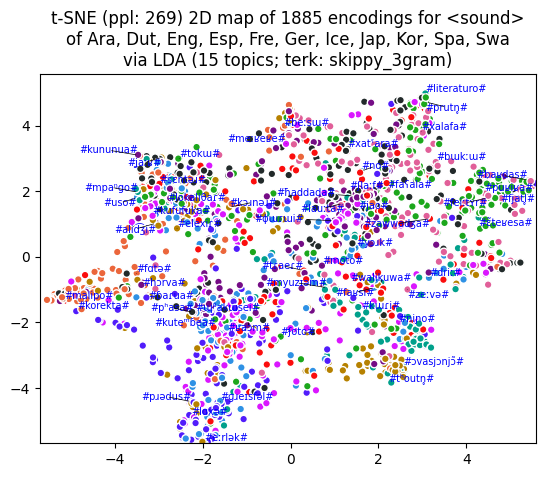

In [228]:
## tSNE の結果の可視化 (2D)

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
## 配色
plt.set_colors = pex.colors.qualitative.Plotly
## labeling
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    
##
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    title_header = f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n"
    title_body = f"of {', '.join([ l.title() for l in sorted([ l[:3] for l in selected_langs])])}\n"
    title_tail = f"via LDA ({n_topics} topics; terk: {lda_term_type})"          
    plt.title(title_header + title_body + title_tail)
    #plt.legend(df['language'])
    plt.show()

# DBSCAN を使ったクラスタリング

In [229]:
## DBSCAN を使ったクラスタリング
from sklearn.cluster import DBSCAN

DBSCAN_uses_UMAP = True
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None

max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
check = False
print(f"Looking for the optimal eps val...")
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


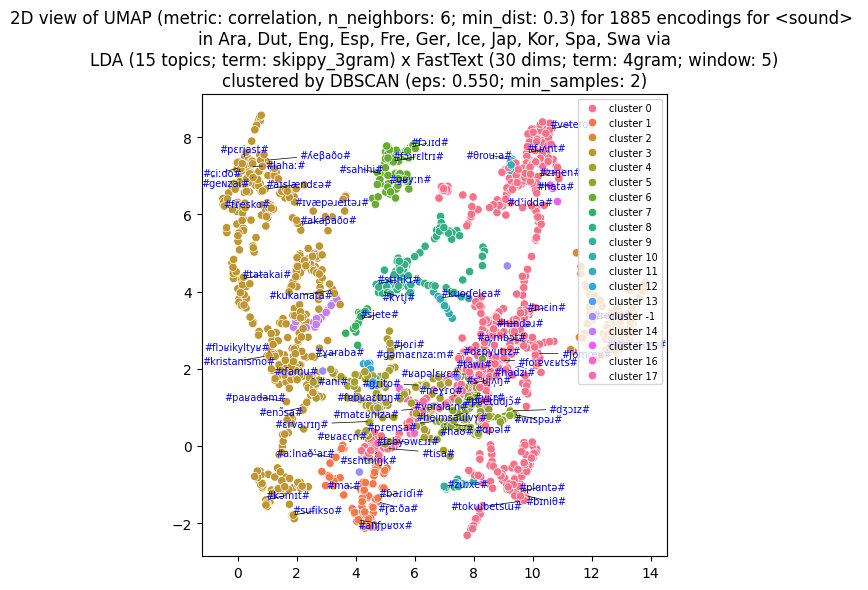

In [230]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(plot_df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_lang_list = f"{', '.join([ l.title() for l in [ l[:3] for l in selected_langs] ])}"
## title_header
df_size = len(plot_df)
if DBSCAN_uses_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_lang_list} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_lang_list} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBSCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

# co-clusteredness に基づく言語間類似度の計算

In [231]:
## co-clusteredness に基づく言語間類似度の計算

import pandas as pd
from sklearn.cluster import DBSCAN

#DBSCAN_uses_UMAP = True # tSNE は有効でないようだ
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2

## 精度を上げるために，クラスター数を多目にする
scaling_factor = 5
max_n_clusters_for_correl = round(len(selected_langs) * scaling_factor)
print(f"max_n_clusters_for_correl")

print(f"Looking for the optimal value for eps...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")

## clusterごとに言語の帰属数を集計
selector_var = 'language'
bindings = zip(doc_fit_df[doc_type], doc_fit_df[selector_var], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = ['form', selector_var, 'cluster'])

selector_names = sorted(set(binding_df[selector_var]))
print(f"selector_names: {selector_names}")

cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")

clusterwise_counts = { selector_name : None for selector_name in selector_names }
for selector_name in selector_names:
    counts = [ ]
    selected = binding_df[ binding_df[selector_var] == selector_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[selector_name] = counts

## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal value for eps...
final result: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selector_names: ['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
cluster ids: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,2,0,1,2,1,2,1,0,0,1,1
1,6,17,3,2,28,10,42,27,16,42,25
2,5,10,15,3,2,15,6,4,22,9,0
3,3,1,1,0,0,0,3,58,21,1,0
4,1,56,79,6,81,25,16,1,6,4,8
5,3,8,12,1,2,1,2,3,6,9,5
6,17,45,4,16,3,19,15,10,2,17,3
7,0,7,0,1,6,3,11,2,0,4,2
8,65,11,4,10,4,3,6,11,0,3,6
9,1,1,0,57,5,3,1,13,2,34,23


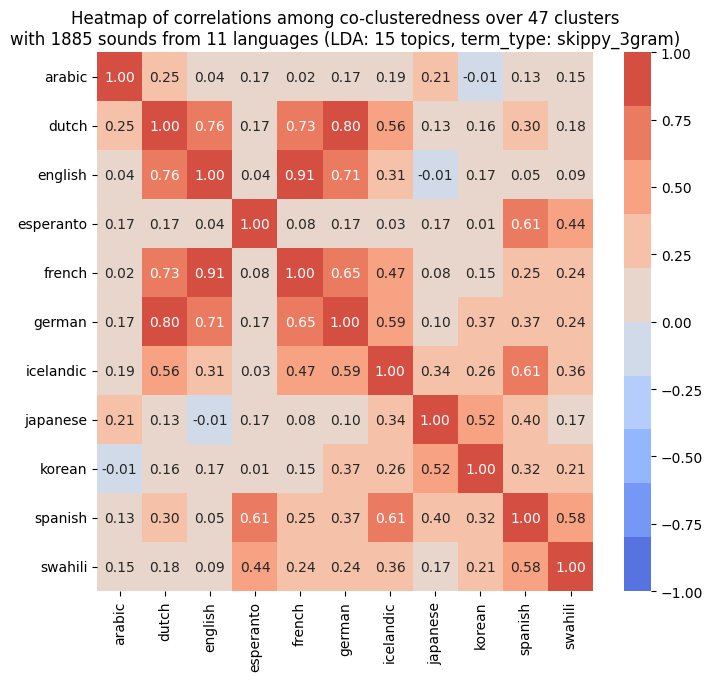

In [232]:
## Heatmap で可視化

import seaborn as sns

counts_df_normalized = (clusterwise_counts_df - clusterwise_counts_df.min())/(clusterwise_counts_df.max() - clusterwise_counts_df.min())
corr_df = counts_df_normalized.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)

n_selectors = len(selector_names)
fig = plt.figure(figsize = (round(n_selectors * 0.7), round(n_selectors * 0.6)))
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_val = f"Heatmap of correlations among co-clusteredness over {len(cluster_ids)} clusters\nwith {len(dbscan_source)} {doc_attr}s from {n_selectors} {selector_var}s (LDA: {n_topics} topics, term_type: {lda_term_type})"
plt.title(title_val)
plt.show()

階層クラスタリングのための部分サンプリングの追加

In [233]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

188 rows are sampled


language
arabic       16
dutch        26
english      23
esperanto    20
french       21
german       16
icelandic    19
japanese     17
korean        7
spanish       9
swahili      14
Name: count, dtype: int64

階層クラスタリングの実行

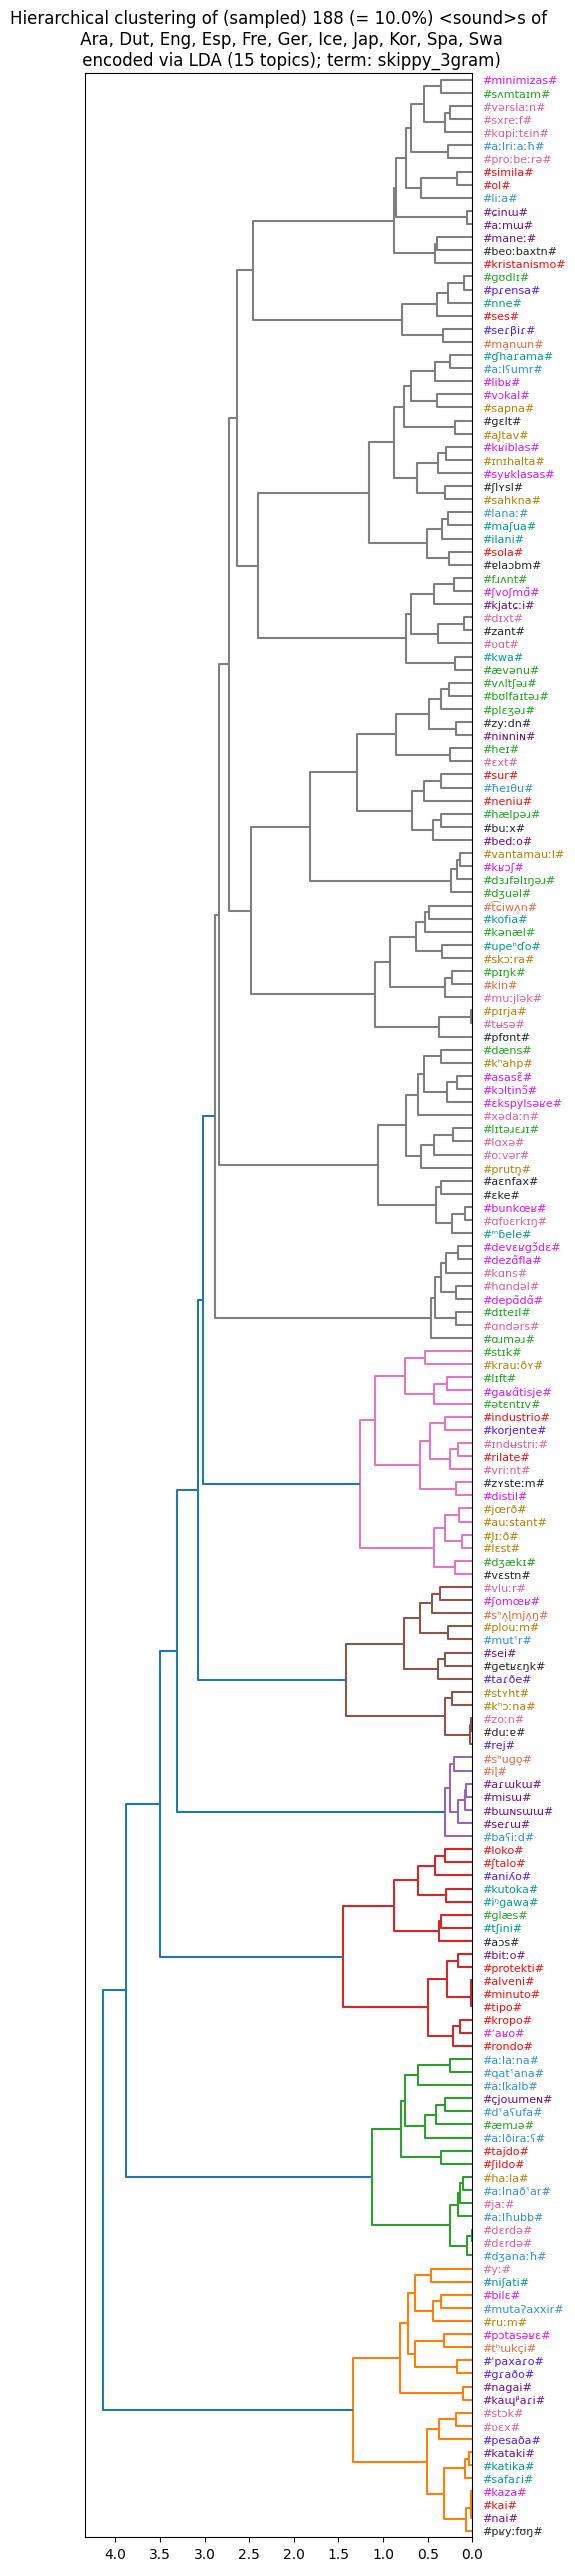

In [234]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title()[:3] for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()
## A few Turkish words will be partially garbled.